# PyTorch - CNN with Attention Variant Model

## Dependencies

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
from pathlib import Path

In [2]:
print(f"Torch Version: {torch.__version__}")

Torch Version: 2.6.0+cpu


In [3]:
device = 'gpu' if torch.cuda.is_available() else 'cpu'

## Load Dataset

In [4]:
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms

In [5]:
worker_info = torch.utils.data.get_worker_info()
print(worker_info is None)

True


In [6]:
BATCH_SIZE = 32
TRAIN_PATH = 'EEGVision-1/train'
VAL_PATH = 'EEGVision-1/valid'
TEST_PATH = 'EEGVision-1/test'

TRANSFORM = transforms.Compose([transforms.ToTensor(),
                                transforms.RandomRotation(10),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                               ])

train_data = ImageFolder(root=TRAIN_PATH, transform=TRANSFORM)
train_dataloader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)

val_data = ImageFolder(root=VAL_PATH, transform=TRANSFORM)
val_dataloader = DataLoader(dataset=val_data, batch_size=BATCH_SIZE, shuffle=False)

test_data = ImageFolder(root=TEST_PATH, transform=TRANSFORM)
test_dataloader = DataLoader(dataset=test_data, batch_size=BATCH_SIZE, shuffle=False)

### Verify Dataset Contents

In [7]:
class_to_idx = train_data.class_to_idx

In [8]:
img, label = next(iter(train_dataloader))
img.shape, label.shape

(torch.Size([32, 3, 224, 224]), torch.Size([32]))

In [9]:
random_idx = torch.randint(0, len(img), size=[1]).item()
random_idx

31

In [10]:
label[random_idx]

tensor(19)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


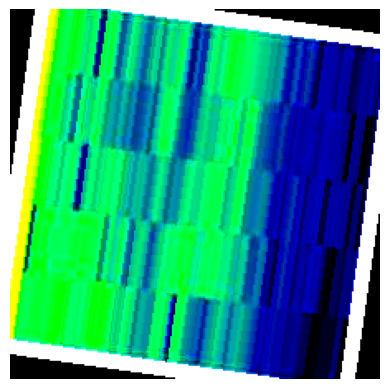

In [11]:
plt.imshow(img[random_idx].permute(1,2,0))
plt.axis('off')
plt.show()

## Attention-CNN Model

In [12]:
from torch import nn

In [22]:
class SpectrCNN(nn.Module):
    def __init__(self, in_chnls=3, hidden_units=16, out_chnls=20):
        super().__init__()
        self.conv_stack = nn.Sequential(
            nn.Conv2d(in_channels=in_chnls, out_channels=hidden_units, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units*2, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units*2, out_channels=hidden_units*4, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Conv2d(in_channels=hidden_units*4, out_channels=hidden_units*8, kernel_size=3, stride=1),
            nn.ReLU(),    
            nn.Conv2d(in_channels=hidden_units*8, out_channels=hidden_units*16, kernel_size=2, stride=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units*16, out_channels=hidden_units*32, kernel_size=2, stride=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            
            nn.MaxPool2d(kernel_size=2, stride=1),
    
            nn.Flatten(),
            nn.Dropout(p=0.4),
            nn.Linear(in_features=225792, out_features=out_chnls),
            nn.Softmax(dim=1)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.conv_stack(x)

In [23]:
model = SpectrCNN()

In [24]:
from torchinfo import summary
summary(model, input_size=(1, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
SpectrCNN                                [1, 20]                   --
├─Sequential: 1-1                        [1, 20]                   --
│    └─Conv2d: 2-1                       [1, 16, 110, 110]         1,216
│    └─ReLU: 2-2                         [1, 16, 110, 110]         --
│    └─Conv2d: 2-3                       [1, 32, 53, 53]           12,832
│    └─ReLU: 2-4                         [1, 32, 53, 53]           --
│    └─Conv2d: 2-5                       [1, 64, 26, 26]           18,496
│    └─ReLU: 2-6                         [1, 64, 26, 26]           --
│    └─Dropout: 2-7                      [1, 64, 26, 26]           --
│    └─Conv2d: 2-8                       [1, 128, 24, 24]          73,856
│    └─ReLU: 2-9                         [1, 128, 24, 24]          --
│    └─Conv2d: 2-10                      [1, 256, 23, 23]          131,328
│    └─ReLU: 2-11                        [1, 256, 23, 23]        

In [27]:
# model.load_state_dict(torch.load('SpectrCNN_state_dictV4.pt'))

### Model Dry Run

In [25]:
features, labels = next(iter(test_dataloader))

In [26]:
features.shape, labels.shape

(torch.Size([32, 3, 224, 224]), torch.Size([32]))

In [27]:
y_hat = model(features)

In [28]:
def acc_fn(y_preds, y_true):
    correct_preds = torch.eq(y_preds, y_true).sum().item()
    return (correct_preds/len(y_true)) * 100

In [29]:
acc_fn(y_hat.argmax(dim=1), label)

0.0

In [30]:
y_hat.argmax(dim=1).shape, label.shape

(torch.Size([32]), torch.Size([32]))

## Model Training

In [31]:
from tqdm.auto import tqdm
from timeit import default_timer as timer

In [33]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, mode='max', 
                                                       patience=3, min_lr=1e-6)

In [34]:
epochs = 50
start_time = timer()
train_loss_list = []
val_loss_list = []
train_acc_list = []
val_acc_list = []

for epoch in tqdm(range(epochs)):
    # Training loop
    train_loss, train_acc = 0, 0
    
    print(f"Epoch: {epoch}\n---------")
    
    for batch, (x_train, y_train) in enumerate(train_dataloader):
        model.train()
        
        # forward pass
        y_preds = model(x_train)
        # loss calculation
        trn_loss = loss_fn(y_preds, y_train)
        train_loss += trn_loss
        # accuracy calculation
        trn_acc = acc_fn(y_preds.argmax(dim=1), y_train)
        train_acc += trn_acc
        # reset gradients
        optimizer.zero_grad()
        # backward pass
        trn_loss.backward()
        # optimization step
        optimizer.step()

        if batch%100==0:
            print(f"Looked at {batch*len(x_train)}/{len(train_data)} samples so far.")

    print(f"Train Loss (before): {train_loss:.4f} | Train Accuracy (before): {train_acc:.4f} %")
    train_loss /= len(train_dataloader)
    train_acc /= len(train_dataloader)
    print(f"Train Loss (after): {train_loss:.4f} | Train Accuracy (after): {train_acc:.4f} %")
    
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)


    
    # validating model performance
    valid_loss, valid_acc = 0, 0
    
    model.eval()
    with torch.inference_mode():
        for x_test, y_test in (val_dataloader):
            # forward pass
            val_preds = model(x_test)
            # loss calculation
            val_loss = loss_fn(val_preds, y_test)
            valid_loss += val_loss
            # accuracy calculation
            val_acc = acc_fn(val_preds.argmax(dim=1), y_test)
            valid_acc += val_acc

        valid_loss /= len(val_dataloader)
        valid_acc /= len(val_dataloader)
        
        val_loss_list.append(valid_loss)
        val_acc_list.append(valid_acc)
        
    print(f'Train Loss: {train_loss:.3f} | Train Accuracy: {train_acc:.3f} % | Test Loss: {valid_loss:.3f} | Test Accuracy: {valid_acc:.3f} %')

    scheduler.step(valid_loss)

end_time = timer()
print(f"Model training time: {((end_time - start_time)/60):.1f} minutes")

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0
---------
Looked at 0/23367 samples so far.
Looked at 3200/23367 samples so far.
Looked at 6400/23367 samples so far.
Looked at 9600/23367 samples so far.
Looked at 12800/23367 samples so far.
Looked at 16000/23367 samples so far.
Looked at 19200/23367 samples so far.
Looked at 22400/23367 samples so far.
Train Loss (before): 2004.1754 | Train Accuracy (before): 24586.6071 %
Train Loss (after): 2.7417 | Train Accuracy (after): 33.6342 %
Train Loss: 2.742 | Train Accuracy: 33.634 % | Test Loss: 2.742 | Test Accuracy: 33.569 %
Epoch: 1
---------
Looked at 0/23367 samples so far.
Looked at 3200/23367 samples so far.
Looked at 6400/23367 samples so far.
Looked at 9600/23367 samples so far.
Looked at 12800/23367 samples so far.
Looked at 16000/23367 samples so far.
Looked at 19200/23367 samples so far.
Looked at 22400/23367 samples so far.
Train Loss (before): 2004.1910 | Train Accuracy (before): 24592.4107 %
Train Loss (after): 2.7417 | Train Accuracy (after): 33.6421 %
Train Loss

KeyboardInterrupt: 

In [35]:
torch.save(model.state_dict(), 'SpectrCNN_state_dictV6.pt')

In [46]:
train_loss = [loss.detach().numpy() for loss in train_loss_list]

In [47]:
val_loss = [loss.detach().numpy() for loss in val_loss_list]

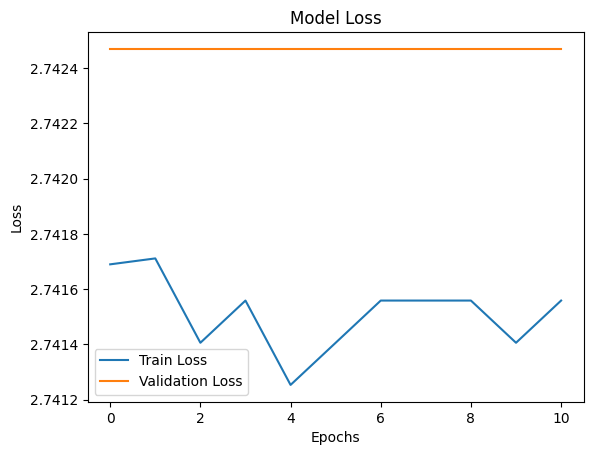

In [70]:
import matplotlib.pyplot as plt
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(np.arange(11), train_loss, label='Train Loss')
plt.plot(np.arange(11), val_loss, label='Validation Loss')
plt.legend()
plt.savefig('eeg_loss.png')
plt.show()

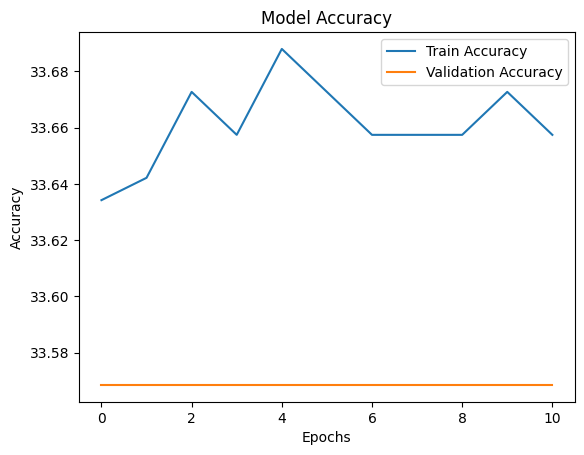

In [71]:
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(np.arange(11), train_acc_list, label='Train Accuracy')
plt.plot(np.arange(11), val_acc_list, label='Validation Accuracy')
plt.legend()
plt.savefig("eeg_accuracy.png")
plt.show()

In [63]:
test_acc_list = []
test_loss_list = []

for x_test, y_test in test_dataloader:
    test_preds = model(x_test)
    test_loss = loss_fn(test_preds, y_test)
    test_acc = acc_fn(test_preds.argmax(dim=1), y_test)
    print(f"Test Accuracy: {test_acc} %")
    print(f"Test Loss: {test_loss}")
    test_loss_list.append(test_loss.detach().numpy())
    test_acc_list.append(test_acc)
    # print(f"test preds: \n{test_preds.argmax(dim=1)}")
    # print(f"\nactual labels:\n {y_test}")

Test Accuracy: 0.0 %
Test Loss: 3.0781545639038086
Test Accuracy: 0.0 %
Test Loss: 3.0781545639038086
Test Accuracy: 0.0 %
Test Loss: 3.0781545639038086
Test Accuracy: 0.0 %
Test Loss: 3.0781545639038086
Test Accuracy: 0.0 %
Test Loss: 3.0781545639038086
Test Accuracy: 0.0 %
Test Loss: 3.0781545639038086
Test Accuracy: 0.0 %
Test Loss: 3.0781545639038086
Test Accuracy: 0.0 %
Test Loss: 3.0781545639038086
Test Accuracy: 0.0 %
Test Loss: 3.0781545639038086
Test Accuracy: 0.0 %
Test Loss: 3.0781545639038086
Test Accuracy: 0.0 %
Test Loss: 3.0781545639038086
Test Accuracy: 0.0 %
Test Loss: 3.0781545639038086
Test Accuracy: 0.0 %
Test Loss: 3.0781545639038086
Test Accuracy: 0.0 %
Test Loss: 3.0781545639038086
Test Accuracy: 0.0 %
Test Loss: 3.0781545639038086
Test Accuracy: 0.0 %
Test Loss: 3.0781545639038086
Test Accuracy: 0.0 %
Test Loss: 3.0781545639038086
Test Accuracy: 0.0 %
Test Loss: 3.0781545639038086
Test Accuracy: 0.0 %
Test Loss: 3.0781545639038086
Test Accuracy: 6.25 %
Test Loss

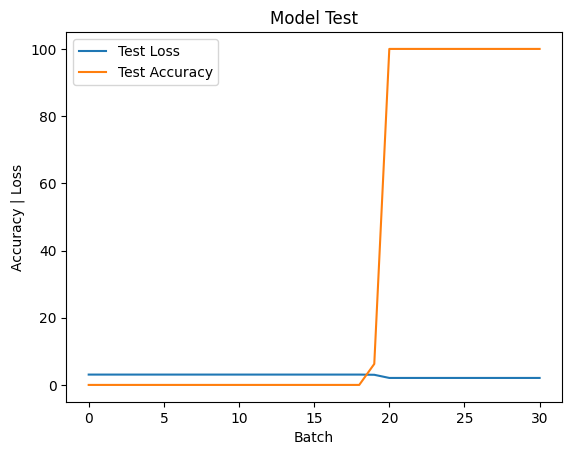

In [67]:
plt.title('Model Test')
plt.xlabel('Batch')
plt.ylabel('Accuracy | Loss')

plt.plot(np.arange(31), test_loss_list, label='Test Loss')
plt.plot(np.arange(31), test_acc_list, label='Test Accuracy')
plt.legend()
plt.savefig('model_test.png')
plt.show()